<a href="https://colab.research.google.com/github/suntiel/ExampleRepo/blob/main/Liv_Sun_MSE125_Pset_3_hba1c_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🩸 HW3 Lab: Blood glucose and the bootstrap

<img src="https://github.com/joshuagrossman/mse125-labs-public/blob/main/week3/img/cgm.jpeg?raw=1" alt= “cgm” width="400" />

## ✅ Setup and data import
In this lab, we will work with blood glucose data from 100 patients with diabetes.
The data are derived from [public datasets](https://public.jaeb.org/datasets/diabetes) provided by the Jaeb Center for Health Research.

In [ ]:
# Load in additional functions
library(tidyverse)
library(lubridate)

# Use three digits past the decimal point
options(digits = 3)

# Format plots with a white background and dark features.
theme_set(theme_bw())

# Increase the default text size of plots.
# If you are *not* working in Google Colab, we recommend commenting
# out this line of code.
theme_update(text = element_text(size = 20))

# Increase the default plot width and height.
# If you are *not* working in Google Colab, we recommend commenting
# out this line of code.
options(repr.plot.width=12, repr.plot.height=8)

# Load in the data
data = read_csv("https://jdgrossman.com/assets/hba1c-cgm-data.csv")

# peek at 10 random rows
sample_n(data, 10)

Rows: 100 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): id, a1c_value, mean_bg, time_in_range

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,a1c_value,mean_bg,time_in_range
<dbl>,<dbl>,<dbl>,<dbl>
69,8.9,163,0.60
59,8.3,235,0.21
50,6.5,123,0.69
64,7.0,158,0.65
61,7.7,122,0.46
65,6.9,154,0.64
9,9.3,237,0.26
7,9.8,200,0.41
11,10.9,271,0.10


## 🩸 Background info on blood glucose, HbA1c, and CGMs

[Diabetes mellitus](https://en.wikipedia.org/wiki/Diabetes) is a group of diseases characterized by an inability of the body to properly maintain healthy blood glucose levels.
Having high blood glucose for long periods of time can lead to [serious health complications](https://www.cdc.gov/diabetes/managing/problems.html), such as nerve damage and heart disease.

The [glycated hemoglobin (HbA1c)](https://en.wikipedia.org/wiki/Glycated_hemoglobin) test was introduced in the late 1970s as a way to monitor long-term trends in blood glucose levels.
HbA1c values above 6.4% are typically indicative of diabetes.
Values above 7% are associated with long-term complications, with higher values associated with more severe complications.
Patients with diabetes are typically instructed to have their blood drawn every three months to monitor their HbA1c.

[Continuous glucose monitors (CGMs)](https://en.wikipedia.org/wiki/Continuous_glucose_monitor) allow patients with diabetes to see a real-time output of their blood glucose levels.
The picture at the top of this lab is an example of a CGM.
The first CGM was introduced in 1999, but CGM adoption did not begin to accelerate until about 10 years later.
Thus, HbA1c measurement is still the gold standard for predicting long-term health outcomes in patients with diabetes, as there simply has not been as much time for CGM measurements to be formally correlated with longer-term health outcomes.

> To see Josh's current CGM output, visit [this website](https://jgrossman-new.herokuapp.com).

In this lab, you will assess the relationship between CGM output and HbA1c among a sample of 100 patients.
For each patient, you have the following data:

1. `a1c_value`: An HbA1c measurement. HbA1c is often abbreviated as A1c.
2. `mean_bg`: The patient's CGM-measured average blood glucose (BG) in the timeframe before their HbA1c was measured.
3. `time_in_range`: The proportion of CGM blood glucose measurements that were in the healthy range of 70 mg/dL to 180 mg/dL. Often abbreviated as TIR.

For the purposes of this assignment, you can assume that the 100 patients in the data were randomly drawn from the same population.

### 🚀 Exercise 1

First, write a function called `get_sample_mean_ci` that constructs a normally-approximated analytic confidence interval for a population mean.

> You should also write and call a helper function called `get_z_crit` that calculates the $z_{\alpha/2}$ value corresponding to a given level of confidence.

`get_sample_mean_ci` should take the following inputs:

1. `x`: a vector of the values in the sample
2. `cl`: the desired confidence level, expressed as a proportion between 0 and 1

The function should return a two-element vector with the lower and upper bounds of your confidence interval.

Using `get_sample_mean_ci` to construct a 95% confidence interval for the the average HbA1c of the population.

In [ ]:
# Constructing a 95% conf interval for A1c
get_z_crit = function(conf_level) {
  alpha = 1 - conf_level
  z = qnorm(1 - alpha / 2)
  return(z)

}

get_sample_mean_ci = function(x, conf_level) {
  xbar = mean(x)
  sd = sd(x)
  n = length(x)
  z = get_z_crit(conf_level)
  moe = z * (sd / sqrt(n))
  lower <- xbar - moe
  upper <- xbar + moe
  return(c(lower, upper))
}

conf_level = 0.95

conf_interval = get_sample_mean_ci(data$a1c_value, conf_level)
print("confidence interval:")
print(conf_interval)

print(data)


[1] "confidence interval:"
[1] 7.59 8.15
# A tibble: 100 × 4
      id a1c_value mean_bg time_in_range
   <dbl>     <dbl>   <dbl>         <dbl>
 1     1       7.8     151          0.64
 2     2       7.6     177          0.5 
 3     3       7.5     158          0.54
 4     4       7.2     166          0.63
 5     5       9.1     250          0.17
 6     6       8.9     183          0.51
 7     7       9.8     200          0.41
 8     8       8.7     180          0.57
 9     9       9.3     237          0.26
10    10      10.1     269          0.19
# ℹ 90 more rows


### 🚀 Exercise 2

(a) Write a function `generate_boot_estimates` to generate `B` bootstrapped synthetic estimates given a sample of data and an estimator.

Your function should take the following inputs:

1. `x`: a vector of the values in the sample
2. `B`: the number of synthetic estimates to generate
3. `f`: a function that converts a vector of values into an estimate. For example, if your estimator is the median, you would pass `f=median` into your function.

Using your function and the patient data, generate 10,000 synthetic estimates of the sample mean HbA1c.

> **Do not print all 10,000 estimates**. Just print the first 10.

In [ ]:
# Making synthetic estimates of A1C using bootstrapping

# Generate one sample
boot_indices = sample(nrow(data), 100, replace = TRUE)
boot_sample = data[boot_indices, ]
# print("One bootstrap sample:")
# print(boot_sample)

a1c_sample_vector = boot_sample$a1c_value
# print(a1c_sample_vector)

# Generate 10000 estimates off the sample.
generate_boot_estimates = function(x, B, f) {
  synth_est_vector = replicate(B, f(sample(x, 100, replace = TRUE)))
  # Return the synthetic estimates.
  return(synth_est_vector)
}

# Generate 10000 estimates
df_vector = generate_boot_estimates(a1c_sample_vector, 10000, mean)

# Print just the first 10 synthetic estimates
print("The first 10 synthetic estimates are ")
print(df_vector[0:10])

[1] "The first 10 synthetic estimates are "
 [1] 8.15 7.80 7.69 7.70 7.86 7.87 8.02 8.20 7.65 7.92


(b) In no more than two sentences, explain the purpose of generating these 10,000 synthetic estimates.



```
# This is formatted as code
```

---
📝
These 10,000 synthetic estimates, each one representing a (synthetic) parallel universe. From here we can create a boostrapped sampling distribution to estimate the standard error.


---

### 🚀 Exercise 3

(a) Write a function `get_bootstrap_ci` to compute a normally-approximated bootstrapped confidence interval and a bootstrapped percentile confidence interval.

- `get_bootstrap_ci` should call the `generate_boot_estimates` function from above.

- `get_bootstrap_ci` should return a two-element list. The first list element should be the normally-approximated interval, and the second list element should be the percentile confidence interval. Each list element should be a two-element vector with the lower and upper bounds of the interval.

- You may find it helpful to ask ChatGPT or another LLM about the difference between vectors and lists in `R`.

Your function should take the following inputs:

1. `x`: a vector of values from the sample
2. `B`: the number of synthetic estimates to generate
3. `f`: a function that converts a vector of values into an estimate.
2. `cl`: the desired confidence level, expressed as a proportion between 0 and 1

Using your function, compute a normally-approximated bootstrapped confidence interval and a percentile confidence interval for the population mean HbA1c.

In [ ]:
get_bootstrap_ci = function(x, B, f, cl) {
  # Define generate_boot_estimates to generate bootstrap estimates
  boot_vector = generate_boot_estimates(x, B, f)

  # Calculate normally approximated bootstrapped CI
  norm_ci = get_sample_mean_ci(boot_vector, cl)

  # Calculate percentile CI
  percentile_ci = quantile(boot_vector, c(((1 - cl)/2), 1 - ((1 - cl)/2))) # finding 0.025 and 0.975 bounds

  # Create a list containing both types of confidence intervals
  result_list = list(norm_ci = norm_ci, percentile_ci = percentile_ci)

  return(result_list)
}

# Example
get_bootstrap_ci(df_vector, 10, mean, 0.95)



$norm_ci
[1] 7.83 7.84

$percentile_ci
 2.5% 97.5% 
 7.82  7.86

(b) In 1-2 sentences, compare the two bootstrapped confidence intervals and the analytic confidence interval computed in Exercise 1. Provide a justification as to why your three intervals are similar or different.

---
📝 Write your answer to Exercise 3b here.

The intervals for the two boostrapped CIs that I just computed are smaller in range, and closer to each other in value, than the analytic CI from Exercise 1.

Bootstrapping captures the variability in the data more accurately, especially when the underlying distribution is not normal or the sample size is small. Analytic confidence interval is less reliable here because it conditions on CLT -- mostly the assumption of normality --being true.


---

### 🚀 Exercise 4

(a) Make two nicely-formatted plots. Each point on your plot should represent one patient.

- Both plots should have HbA1c on the y-axis.

- The first plot should have mean blood glucose on the x-axis.

- The second plot should have time in range on the x-axis.

- The axis labels should indicate the units of each measurement. Make sure to read the background information above to identify the units.

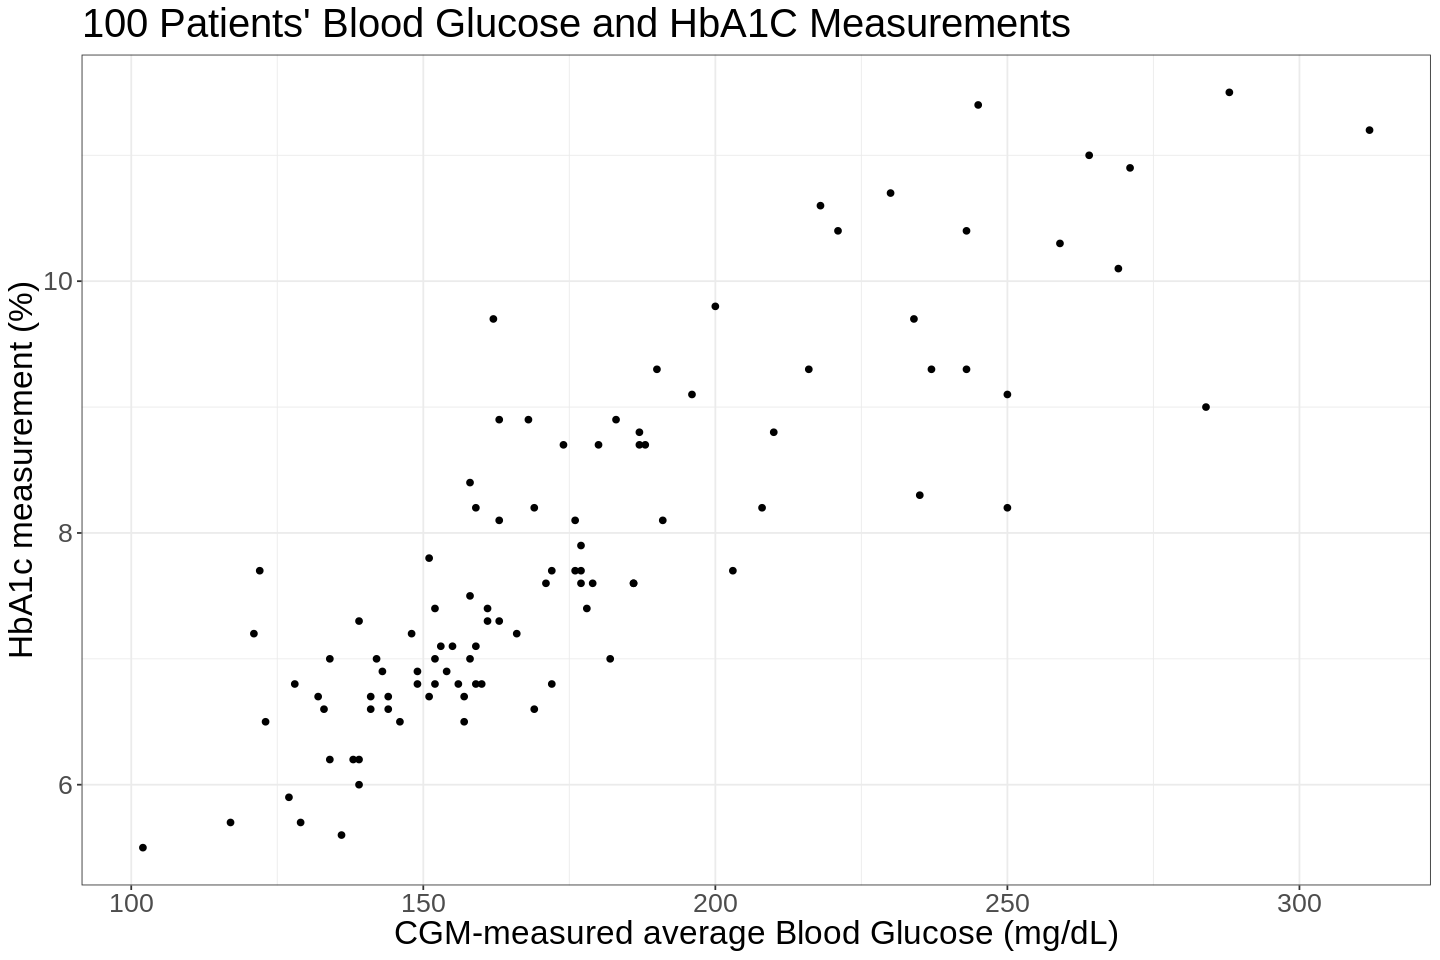

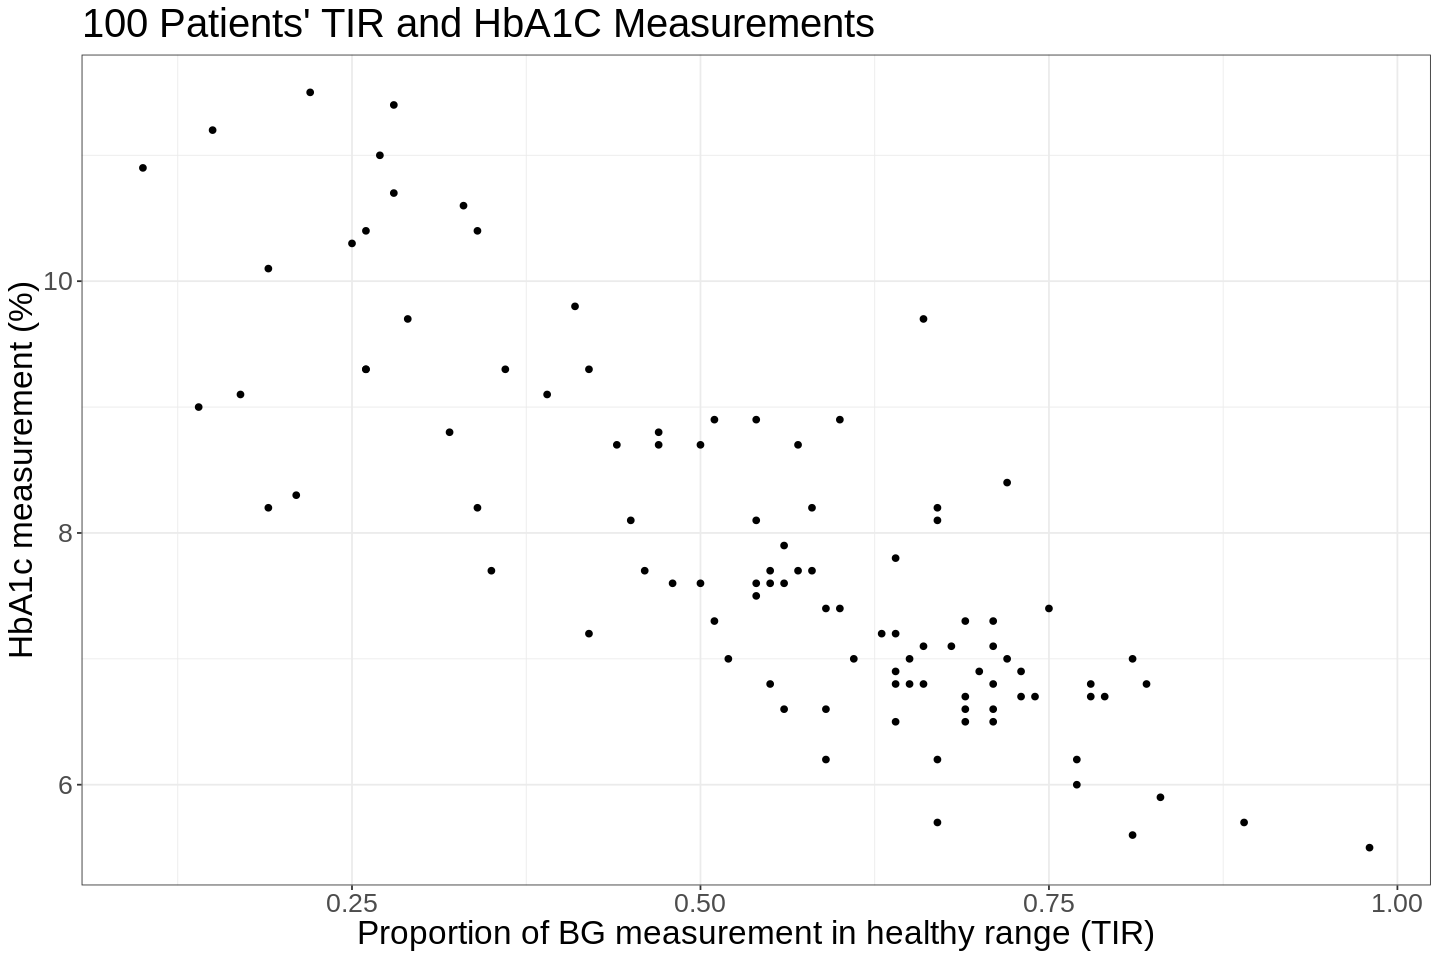

In [ ]:
# Your code here!
# Plot 1: glucose (x) to A1C (y)

ggplot(data, aes(data$mean_bg, y = data$a1c_value)) +
  geom_point() +
  labs(
    title = "100 Patients' Blood Glucose and HbA1C Measurements",
    x = "CGM-measured average Blood Glucose (mg/dL)",
    y = "HbA1c measurement (%)")

# Plot 2: time in range (x) to A1C (y)

ggplot(data, aes(data$time_in_range, y = data$a1c_value)) +
  geom_point() +
  labs(
    title = "100 Patients' TIR and HbA1C Measurements",
    x = "Proportion of BG measurement in healthy range (TIR)",
   y = "HbA1c measurement (%)")
  # scale_y_continuous(breaks = seq(0, 12, by = 1), labels = seq(0, 12, by = 1)) +
  # scale_x_continuous(breaks = seq(0, 350, by = 25), labels = seq(0, 350, by = 25))





  # theme_minimal() +
  # theme(panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank()) +

(b) In 1-2 sentences, describe any patterns you observe in your plots.

---
📝 Write your answer to Exercise 4b here.

Blood glucose and HBA1C are positively correlated,  TIR and HBA1C are negatively correlated, and both plots seem somewhat linear. This makes sense because higher amounts of blood glucose suggest that a lesser proportion is in the (low) healthy range, both of which are correlated with a higher percentage of HBA1C measurement.


---

### 🎶 Interlude: Lines of best fit

Using a pencil, you could likely draw a [line of best fit](https://en.wiktionary.org/wiki/line_of_best_fit) on the plots above.

But, how could we mathematically define the best-fitting line? One approach is to minimize the sum of squared vertical distances from each point to the line.

🖼️ Here's a picture:

<img src="https://github.com/joshuagrossman/mse125-labs-public/blob/main/week3/img/minimize-sum-of-squares.png?raw=1" alt= "minimize sum of squares" width="400" />

In other words, we want to choose the slope and intercept values that minimize the total area of all of the dotted squares.

Here is the same statement expressed mathematically:

$$ \underset{\text{slope}, \text{intercept}}{\mathrm{arg\,min}} \sum_{i=1}^n \left(y_i - (\text{slope}*x_i + \text{intercept}) \right)^2 ,$$

where $(x_i, y_i)$ represent the coordinates of each observation $i$.

By taking partial derivatives with respect to the $\text{slope}$ and $\text{intercept}$ parameters, we can show the following formulas provide the optimal slope and intercept:

$$ \text{slope}_\text{optimal} = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2} $$

$$ \text{intercept}_\text{optimal} = \bar{y} - \text{slope}_\text{optimal} * \bar{x} $$

### 🚀 Exercise 5

Write a function `get_optimal_slope` to compute the optimal slope parameter given inputted data.

> Your function should implement the formula above. Do you not use an outside function like `lm` to calculate the optimal slope.
>
> Optional exercise: You could also write a function `get_optimal_intercept`.

`get_optimal_slope` should take the following input:

1. `coords`: a list of (x,y) coordinates, with each element corresponding to one data point.

> You may find the `map2` function helpful for "zipping" a vector of x-coordinates and a vector of y-coordinates into a list of (x,y) coordinates.
>
> The `map` function may also come in handy for extracting a vector of just the x coordinates from a list of (x,y) coordinates.
>
> You may find it helpful to ask ChatGPT or another LLM for some helpful examples of using `map` and `map2`.

Using your function, identify the optimal slope for each the two plots from Exercise 4.

In [ ]:
# get_optimal_slope
# inputs is coords: a list of (x, y) coordinates

get_optimal_slope = function(coords) {

}

get_optimal_slope(coor)
# using the function to find the slopes of 2 earlier plots
get_optimal_slope()


### 🚀  Exercise 6

Using a combination of the functions you have written above, and any additional code you might need, compute 95% bootstrapped normal and percentile confidence-intervals for the optimal slope of each plot from Exercise 4.

In total, you should have four confidence intervals.


In [ ]:
# Your code here!



### 🚀 Exercise 7

Based on your results from this entire lab, would you be comfortable allowing patients with diabetes to skip having their HbA1c recorded, and instead use your lines of best fit to predict their HbA1c every three months? If yes, why? If not, would you use your line of best fit for any other purpose? Answer in no more than five sentences.

Hint: You may find this [FAQ page](https://provider.dexcom.com/what-glucose-management-indicator-gmi) useful. You may also find it interesting to compare your optimal slope for mean glucose (and optimal intercept, if applicable) to the official glucose management indicator (GMI) formula on the same page. GMI is used in endocrinology clinics around the world to help patients interpret their CGM readings.

---

📝 Write your answer to Exercise 7 here.


---